In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import pickle
from darts.timeseries import TimeSeries
from darts.models import RegressionModel
from sklearn.linear_model import Ridge
from darts.utils.missing_values import fill_missing_values as darts_fill_na
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer, InvertibleMapper

In [2]:
csv_dfs = {}
csv_dfs['bq-results-20240418-170723-1713460063623'] = pd.read_csv('data/bq-results-20240418-170723-1713460063623.csv')

# Training

## Process Data

### Biometrics

In [5]:
biometrics = csv_dfs['bq-results-20240418-170723-1713460063623']
biometrics.drop_duplicates(subset=['CloudId', 'BiometricName', 'MeasuredOnUTC', 'Value'], keep='first', inplace=True)

def clean_timestamp(ts_str):
    clean_str = re.sub(r'(\d+:\d+:\d+)(\.\d+)?', r'\1', ts_str)
    return clean_str

biometrics['MeasuredOn'] = biometrics['MeasuredOnUTC'].apply(clean_timestamp)
biometrics['MeasuredOn'] = pd.to_datetime(biometrics['MeasuredOn'], errors='coerce')
biometrics['MeasuredOnDate'] = biometrics['MeasuredOn'].dt.date
biometrics['MeasuredOnDay'] = biometrics['MeasuredOn'].dt.dayofyear
biometrics['MeasuredOnWeek'] = biometrics['MeasuredOn'].dt.isocalendar().week
biometrics['MeasuredOnYear'] = biometrics['MeasuredOn'].dt.year
biometrics.sort_values('MeasuredOnWeek', inplace=True)

In [6]:
bms = biometrics.drop(columns=['Age', 'Gender', 'MeasureProvidedBy', 'MeasuredOnUTC', 'MeasuredOn', 'MeasuredOnDate', 'MeasuredOnYear'])
bms = bms.groupby(['CloudId', 'BiometricName', 'MeasuredOnWeek']).agg({'Value': 'mean'}).reset_index()
bms.sample(5)

,CloudId,BiometricName,MeasuredOnWeek,Value
512206,f3af4b2054866a70760b53b22a232d4c5f2562b8,Weight,39,58.7
389957,b8c345623a642fd544d8863be3cabfbc58c9b75d,Height,18,171.0
253092,7762bec3ba97d51f876e5552fafc83c02886af48,Left Leg Fat Perc Score,27,-1.0
147430,464cc919f4382b60dfedd7a9cbf1094218776d31,Weight,29,91.0
507782,f20644c63c5b32a507d273723c5ca8b2be297d13,Trunk Fat Free Mass,47,27.4


In [7]:
grouped_bms = bms.groupby(['CloudId', 'BiometricName']).agg({'MeasuredOnWeek': [list, 'count'], 'Value': list})
grouped_bms = grouped_bms.reset_index()
grouped_bms.sample(5)

CloudId               BiometricName  \
                                                                               
124920  882efcb1b17a83313b5f5c3ce4e8b475ca7da956  Basal Metabolic Rate Score   
199886  da843297f71b368c2688196e33d958cbe449afab      Left Arm Fat Free Mass   
54186   3a0e4d1815d28aa527fcee27bc3f322e90ec484a                    Fat Mass   
63364   445d2f49e3d6f91047938994d18cbb2f1643d2f1          Right Arm Fat Perc   
65757   47a2e612aa4f439001d8a7549551fac1198013e7     Right Arm Fat Free Mass   

       MeasuredOnWeek                   Value  
                 list count              list  
124920   [25, 27, 38]     3  [9.0, 9.0, 10.0]  
199886       [27, 30]     2        [4.6, 4.5]  
54186            [27]     1            [23.7]  
63364            [22]     1            [38.0]  
65757        [38, 50]     2        [2.2, 2.2]

Use only (CloudId, BiometricName) pairs with more than 3 measurements and spanning over at least 24 weeks.

In [8]:
has_long_interval = grouped_bms[('MeasuredOnWeek', 'list')].apply(lambda x: max(x) - min(x) >= 24)
has_many_measurements = grouped_bms[('MeasuredOnWeek', 'count')] > 3
print(f'Total number of (CloudId, BiometricName) pairs: {len(grouped_bms)}')
print(f'Number of pairs with long interval: {has_long_interval.sum()} ({has_long_interval.sum() / len(grouped_bms) * 100:.2f}%)')
print(f'Number of pairs with many measurements: {has_many_measurements.sum()} ({has_many_measurements.sum() / len(grouped_bms) * 100:.2f}%)')
print(f'Number of pairs with both long interval and many measurements: {(has_long_interval & has_many_measurements).sum()} ({(has_long_interval & has_many_measurements).sum() / len(grouped_bms) * 100:.2f}%)')
filtered_group_bms = grouped_bms[has_long_interval & has_many_measurements]

Total number of (CloudId, BiometricName) pairs: 234079
Number of pairs with long interval: 38935 (16.63%)
Number of pairs with many measurements: 38991 (16.66%)
Number of pairs with both long interval and many measurements: 25394 (10.85%)


In [9]:
filtered_bms = filtered_group_bms.explode(column=[('MeasuredOnWeek', 'list'), ('Value', 'list')], ignore_index=True)
filtered_bms = filtered_bms.drop(columns=[('MeasuredOnWeek', 'count')])
filtered_bms.columns = [col[0] for col in filtered_bms.columns]
filtered_bms = filtered_bms.astype({'MeasuredOnWeek': 'int32', 'Value': 'float64'})
filtered_bms.sample(5)

,CloudId,BiometricName,MeasuredOnWeek,Value
52892,4bc3b6312320296dd8a3103d9840cddc859d39c7,BMI,27,27.7
10843,0e1764633601705a76b6fd2c48ced042ad10b87b,Metabolic Age,22,31.0
4004,0704e42f52e4b9cb40b5d7f0f7a075fc135ddd05,Trunk Muscle Mass Score,22,0.0
10429,0ceb0dc9bb6ef4f6203d8d1152221d5b145f7bd6,Right Leg Muscle Mass Score,21,2.0
159424,ed075493c49a99af3d05182f6319e18f05c38a2e,HR At Rest,39,72.0


Compute time series for each Cloud ID, Biomertric pair

In [10]:
bms_df = filtered_bms.groupby(['CloudId', 'BiometricName']).agg({'MeasuredOnWeek': list, 'Value': list}).reset_index()
bms_df.sample(5)

,CloudId,BiometricName,MeasuredOnWeek,Value
17640,abb9615e8abe222d513eb88a1b04b25211805e18,Trunk Fat Free Mass,"[22, 23, 32, 34, 38, 39, 48]","[43.8, 43.9, 44.5, 44.5, 43.8, 44.0, 44.05]"
18089,b03a953223f6e87e8260641a75c29a105869f126,Muscle Mass,"[21, 25, 34, 39, 48]","[55.7, 54.5, 56.0, 54.5, 53.8]"
23155,ec8b9031a8efc8ee5da5095ca233a92a7b9543eb,Basal Metabolic Rate,"[23, 25, 27, 30, 32, 38, 39, 41, 46, 47, 48, 50]","[1590.0, 1587.5, 1556.0, 1546.0, 1545.0, 1533...."
11390,70a8ff66c125e2b03b4a47e557bf8e3c8bbf5684,Trunk Fat Mass,"[18, 38, 39, 52]","[50.7, 32.8, 41.9, 33.5]"
20062,c56958132a920721782008f9f39a4b5e607f368b,Trunk Fat Perc,"[20, 22, 25, 34, 36, 38, 39, 41, 47]","[20.5, 20.5, 22.4, 18.8, 19.5, 18.25, 17.35, 1..."


In [11]:
bms_df.rename(columns={'BiometricName': 'Name', 'MeasuredOnWeek': 'Week', 'Value': 'Value'}, inplace=True)

### Static Features

Add gender and age as static covariates

In [12]:
static_cov_df = biometrics[['CloudId', 'Gender', 'Age']].drop_duplicates(subset='CloudId')

df = bms_df.merge(static_cov_df, on='CloudId')
reordered_cols = ['CloudId', 'Gender', 'Age', 'Name', 'Week', 'Value'] 
df = df.reindex(columns=reordered_cols)

### Exercise Data

In [13]:
exercises = pd.read_pickle('data/exercise_df.pkl')

In [14]:
exercises_df = exercises.groupby('CloudId').agg(
    {
    'Week': list,
    'total_calories_week': list,
    'total_minutes_week': list,
    'cardio_calories_week': list,
    'cardio_minutes_week': list,
    'isotonic_calories_week': list,
    'isotonic_minutes_week': list,
    'avg_duration_per_workout': list,
    'avg_calories_per_workout': list,
    'avg_metsmin_workout': list,
    'avg_isotonic_workouts': list,
    'avg_cardio_workouts': list
     }
).reset_index()

In [15]:
ts_df = df.merge(exercises_df, on='CloudId')

# remove _x and _y from column names
def strip_col_suffix(col):
    return re.sub(r'_[xy]$', '', col)

ts_df.columns = pd.MultiIndex.from_tuples(
    [('CloudId', ''), ('Gender', ''), ('Age', '')] + 
    [('Biometrics', strip_col_suffix(col)) for col in ts_df.columns[3:6]] +
    [('Exercise', strip_col_suffix(col)) for col in ts_df.columns[6:]])

In [16]:
ts_df.to_pickle('processed_dataset.pkl')

### Compare time spans

## TimeSeries Creation

Other tasks:
- Exercise features should be encoded as covariates
- Month could also be encoded as covariate
- Consider using other abundant biometrics as covariates

In [17]:
ts_df = pd.read_pickle('processed_dataset.pkl')

In [18]:
ex_df = ts_df[['CloudId', 'Exercise']].drop_duplicates(subset=('CloudId', ''))
bm_df = ts_df[['CloudId', 'Gender', 'Age', 'Biometrics']]

In [20]:
def create_bm_timeseries(row):
    times = pd.Index(row[('Biometrics', 'Week')])
    values = row[('Biometrics', 'Value')]
    covs = pd.DataFrame(data={ 'Gender': [row[('Gender', '')]], 'Age': [row[('Age', '')]] })
    ts = TimeSeries.from_times_and_values(times=times, values=values, columns=[row[('Biometrics', 'Name')]], static_covariates=covs, freq=1)
    filled_ts = darts_fill_na(ts, fill='auto').astype(np.float32)
    return filled_ts

def create_ex_timeseries(row):
    times = pd.Index(row[('Exercise', 'Week')])
    agg_ts = None
    for col in ex_df['Exercise'].columns:
        if col == 'Week':
            continue
        values = row[('Exercise', col)]
        ts = TimeSeries.from_times_and_values(times=times, values=values, columns=[col], freq=1)
        ts = darts_fill_na(ts, fill=0.).astype(np.float32)
        if agg_ts is None:
            agg_ts = ts
        else:
            agg_ts = agg_ts.stack(ts)
    return agg_ts

In [21]:
bm_tms = bm_df.apply(create_bm_timeseries, axis=1)
bm_df.insert(len(bm_df.columns), ('Biometrics', 'TimeSeries'), bm_tms)

In [22]:
ex_tms = ex_df.apply(create_ex_timeseries, axis=1)
ex_df.insert(len(ex_df.columns), ('Exercise', 'TimeSeries'), ex_tms)

Create dataframe with all necessary timeseries

In [23]:
train_df = bm_df.loc[:, [('CloudId', ''), ('Gender', ''), ('Age', ''), ('Biometrics', 'Name'), ('Biometrics', 'TimeSeries')]]
train_df.columns = ['CloudId', 'Gender', 'Age', 'Biometric', 'BiometricTimeSeries']

In [24]:
ex_df_stripped = ex_df.loc[:, [('CloudId', ''), ('Exercise', 'TimeSeries')]]
ex_df_stripped.columns = ['CloudId', 'ExercisesTimeSeries']

In [25]:
train_df = train_df.merge(ex_df_stripped, on='CloudId')

In [26]:
train_df.to_pickle('timeseries_dataset.pkl')

Set up data normalization pipeline

## Fit Model

In [5]:
train_df = pd.read_pickle('timeseries_dataset.pkl')

In [6]:
target_bm = 'Weight'

train_set = train_df[train_df.Biometric == target_bm]
exercises_timeseries = train_set.ExercisesTimeSeries.tolist()
biometric_timeseries = train_set.BiometricTimeSeries.tolist()

In [7]:
interesected_exercises_timeseries = [x.slice_intersect(y) for x,y in zip(exercises_timeseries, biometric_timeseries)]
interesected_biometrics_timeseries = [x.slice_intersect(y) for x,y in zip(biometric_timeseries, exercises_timeseries)]

In [8]:
mask = [len(ts) >= 24 for ts in interesected_exercises_timeseries]

masked_exercises_timeseries = [ts for ts, m in zip(interesected_exercises_timeseries, mask) if m]
masked_biometrics_timeseries = [ts for ts, m in zip(interesected_biometrics_timeseries, mask) if m]

In [13]:
# Pipeline for biometrics
static_cov_transformer = StaticCovariatesTransformer(name="Encoder")
log_transformer = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")   
train_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")
preprocess_pipeline = Pipeline([static_cov_transformer, log_transformer])

# Pipeline for exercise
exercise_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")

In [14]:
target = preprocess_pipeline.fit_transform(masked_biometrics_timeseries)

In [15]:
past_cov = exercise_scaler.fit_transform(masked_exercises_timeseries)

In [16]:
model = RegressionModel(
    model=Ridge(),
    lags=4,
    lags_past_covariates=4,
    output_chunk_length=12
)
model.fit(series=target, past_covariates=past_cov)

RegressionModel(lags=4, lags_past_covariates=4, lags_future_covariates=None, output_chunk_length=12, output_chunk_shift=0, add_encoders=None, model=Ridge(), multi_models=True, use_static_covariates=True)

In [17]:
preds = model.predict(12, target, past_cov)
unnorm_preds = preprocess_pipeline.inverse_transform(preds, partial=True)

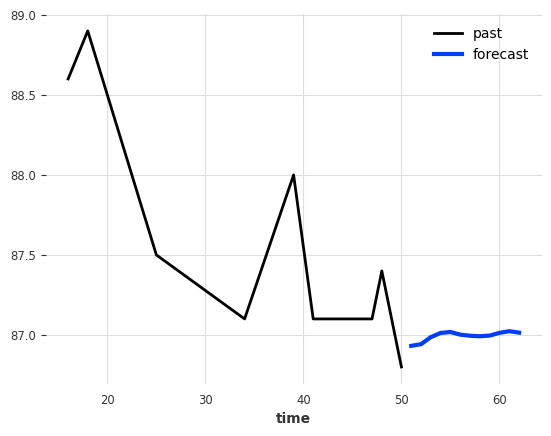

In [18]:
i = np.random.randint(0, len(target))
masked_biometrics_timeseries[i].plot(label='past')
unnorm_preds[i].plot(label='forecast', lw=3)
plt.legend()
plt.show()

Save model and data preprocessor

In [19]:
model.save("weight_model.pkl")

In [20]:
pickle.dump(preprocess_pipeline, open('weight_preprocessor.pkl', 'wb'))

In [21]:
pickle.dump(exercise_scaler, open('weight_scaler.pkl', 'wb'))

# Explainability

In [31]:
from darts.explainability.shap_explainer import ShapExplainer

In [32]:
shap_explainer = ShapExplainer(model, target, past_cov)

In [33]:
pickle.dump(shap_explainer, open('weight_shap_explainer.pkl', 'wb'))

In [80]:
shap_explainer = pickle.load(open('weight_shap_explainer.pkl', 'rb'))

def get_shap_values(target, past_cov):
    explainability_res = shap_explainer.explain(target, past_cov)
    comp_list = explainability_res.get_feature_values(1).components.to_list()
    drop_comp_list = [x for x in comp_list if any([x.startswith(y) for y in explainability_res.available_components])]

    df = explainability_res.get_explanation(3).drop_columns(drop_comp_list).pd_dataframe()

    lag_columns = [col for col in df.columns if 'lag-' in col]
    prefixes = set(col.rsplit('_', 1)[0] for col in lag_columns)

    for prefix in prefixes:
        lag_cols = [col for col in lag_columns if col.startswith(prefix)]
        df[f'{prefix}'] = df[lag_cols].mean(axis=1)

    df = df.drop(columns=lag_columns).reset_index()
    return df

In [81]:
%%capture
shap_df = get_shap_values(target[0], past_cov[0])

In [82]:
shap_df

component,time,Gender_statcov_target_Weight,Age_statcov_target_Weight,cardio_calories_week_pastcov,isotonic_minutes_week_pastcov,avg_calories_per_workout_pastcov,cardio_minutes_week_pastcov,avg_metsmin_workout_pastcov,isotonic_calories_week_pastcov,avg_cardio_workouts_pastcov,avg_isotonic_workouts_pastcov,avg_duration_per_workout_pastcov,total_minutes_week_pastcov,total_calories_week_pastcov
0,20,-0.000458,0.00028,0.000090,0.000139,0.000017,-0.000020,1.606217e-05,-0.000089,-0.000050,0.000178,0.000049,-6.769154e-08,-0.000238
1,21,-0.000458,0.00028,-0.000127,0.000832,-0.000081,0.000256,4.052317e-05,-0.000324,-0.000071,-0.000398,0.000146,1.619603e-04,-0.000352
2,22,-0.000458,0.00028,-0.000163,0.000376,-0.000046,0.000243,-1.903846e-05,-0.000089,-0.000030,-0.000315,0.000158,-3.005246e-04,0.000231
3,23,-0.000458,0.00028,0.000383,0.000060,0.000003,-0.000412,-7.530626e-06,-0.000039,0.000039,0.000140,0.000089,-1.033106e-04,-0.000047
4,24,-0.000458,0.00028,0.000138,0.000243,0.000012,-0.000174,1.182124e-05,-0.000091,0.000038,-0.000041,0.000020,2.159427e-05,-0.000092
5,25,-0.000458,0.00028,-0.000080,0.000108,0.000010,0.000068,1.481666e-05,-0.000016,0.000032,-0.000050,0.000001,1.686112e-05,-0.000030
6,26,-0.000458,0.00028,-0.000139,-0.000221,-0.000025,0.000130,-1.367897e-05,0.000070,0.000025,0.000174,0.000045,-1.894956e-05,0.000031
7,27,-0.000458,0.00028,0.000082,-0.000279,0.000007,-0.000125,7.155806e-06,0.000108,0.000058,0.000164,0.000010,-2.527287e-05,0.000082
8,28,-0.000458,0.00028,0.000209,-0.000462,0.000018,-0.000352,-3.788016e-06,0.000162,0.000142,0.000249,-0.000004,-8.253642e-07,0.000141
9,29,-0.000458,0.00028,0.000042,-0.000520,-0.000061,-0.000145,-3.093155e-06,0.000195,0.000080,0.000239,0.000115,1.164902e-04,0.000064


# Inference

In [54]:
model = RegressionModel.load("weight_model.pkl")
preprocess_pipeline = pickle.load(open('weight_preprocessor.pkl', 'rb'))
scaler = pickle.load(open('weight_scaler.pkl', 'rb'))

In [55]:
def create_bm_timeseries(row):
    times = pd.Index(row[('Biometrics', 'Week')])
    values = row[('Biometrics', 'Value')]
    covs = pd.DataFrame(data={ 'Gender': [row[('Gender', '')]], 'Age': [row[('Age', '')]] })
    ts = TimeSeries.from_times_and_values(times=times, values=values, columns=[row[('Biometrics', 'Name')]], static_covariates=covs, freq=1)
    filled_ts = darts_fill_na(ts, fill='auto').astype(np.float32)
    return filled_ts

def create_ex_timeseries(row):
    times = pd.Index(row[('Exercise', 'Week')])
    agg_ts = None
    for col in ex_df['Exercise'].columns:
        if col == 'Week':
            continue
        values = row[('Exercise', col)]
        ts = TimeSeries.from_times_and_values(times=times, values=values, columns=[col], freq=1)
        ts = darts_fill_na(ts, fill=0.).astype(np.float32)
        if agg_ts is None:
            agg_ts = ts
        else:
            agg_ts = agg_ts.stack(ts)
    return agg_ts

In [77]:
ts_df = pd.read_pickle('processed_dataset.pkl')
ex_df = ts_df[['CloudId', 'Exercise']].drop_duplicates(subset=('CloudId', ''))
bm_df = ts_df[['CloudId', 'Gender', 'Age', 'Biometrics']]

cloud_ids = np.intersect1d(ex_df.CloudId.unique(), bm_df.CloudId.unique())

In [209]:
# Use samples from the dataset
# weeks = sliced_train_set[i].time_index
# values = sliced_train_set[i].values()
# covs = sliced_train_set[i].static_covariates

# Use your own values
weeks = pd.Index([0,4,10,16,21,24,26])
values = [82, 84, 85, 82, 84, 86, 87][::-1]
covs = pd.DataFrame(data={'Gender': ['M'], 'Age': [30]})

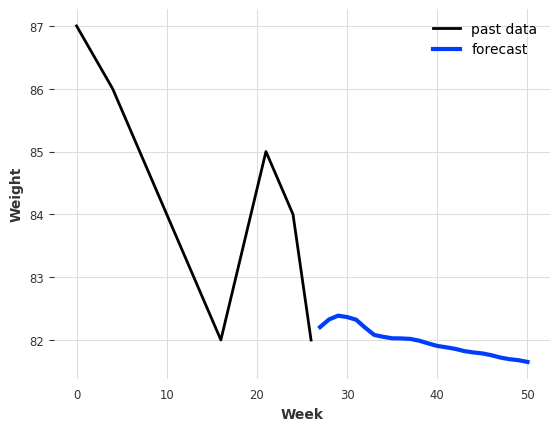

In [220]:
ts = TimeSeries.from_times_and_values(times=weeks, values=values, static_covariates=covs, freq=1)
filled_ts = darts_fill_na(ts, fill='auto').astype(np.float32)

trans_ts = preprocess_pipeline.transform(filled_ts)
pred = model.predict(24, [trans_ts])
unnorm_pred = preprocess_pipeline.inverse_transform(pred)[0]

filled_ts.plot(label='past data')
unnorm_pred.plot(label='forecast', lw=3)
plt.xlabel('Week')
plt.ylabel('Weight')
plt.show()

# Get a user's data

In [45]:
processed_biometrics = pd.read_pickle('processed_long_biometrics.pkl')
valid_cloud_ids = processed_biometrics.CloudId.unique()

In [ ]:
targets = ['Weight', 'Fat mass Perc', 'Muscle Mass', 'HR at Rest']

In [68]:
i = np.random.randint(0, len(valid_cloud_ids))
cloud_id = valid_cloud_ids[i]

In [77]:
user_bms = processed_biometrics[(processed_biometrics.CloudId == cloud_id) & (processed_biometrics.BiometricName.isin(targets))]
user_bms_filtered = user_bms[['BiometricName', 'MeasuredOnWeek', 'Value', 'Gender', 'Age']]
user_bms_filtered

,BiometricName,MeasuredOnWeek,Value,Gender,Age
22390,Fat mass Perc,"[19, 39, 46, 50]","[40.2, 38.3, 40.6, 39.0]",F,20
22407,Muscle Mass,"[19, 39, 46, 50]","[53.4, 54.9, 51.7, 53.3]",F,20
22435,Weight,"[19, 39, 46, 50]","[94.0, 93.7, 91.7, 92.0]",F,20


In [86]:
user_gender = user_bms_filtered['Gender'].iloc[0]
user_age = user_bms_filtered['Age'].iloc[0]

biometric_data_list = user_bms_filtered.drop(['Gender', 'Age'], axis=1).to_dict(orient='records')

In [91]:
biometric_data_list

[{'BiometricName': 'Fat mass Perc',
  'MeasuredOnWeek': [19, 39, 46, 50],
  'Value': [40.2, 38.3, 40.6, 39.0]},
 {'BiometricName': 'Muscle Mass',
  'MeasuredOnWeek': [19, 39, 46, 50],
  'Value': [53.4, 54.9, 51.7, 53.3]},
 {'BiometricName': 'Weight',
  'MeasuredOnWeek': [19, 39, 46, 50],
  'Value': [94.0, 93.7, 91.7, 92.0]}]

# Exercise Data

In [38]:
processed_biometrics = pd.read_pickle('processed_biometrics.pkl')

In [16]:
exercises = pd.read_pickle('data/exercise_df.pkl')

In [47]:
exercises_per_user = exercises.groupby('CloudId').agg(
    {
    'Week': list,
    'total_calories_week': list,
    'total_minutes_week': list,
    'cardio_calories_week': list,
    'cardio_minutes_week': list,
    'isotonic_calories_week': list,
    'isotonic_minutes_week': list,
    'avg_duration_per_workout': list,
    'avg_calories_per_workout': list,
    'avg_metsmin_workout': list,
    'avg_isotonic_workouts': list,
    'avg_cardio_workouts': list
     }
)

In [50]:
merged_df = processed_biometrics.merge(exercises_per_user, on='CloudId')